# Smart Trash Metric for Pittsburgh Neighborhoods

In this notebook, I build a **smart-trash-based metric** to quantify how well-served each Pittsburgh neighborhood is in terms of waste collection infrastructure.

Smart trash containers are waste bins equipped with sensors or smart technologies that monitor fill levels in real time, helping optimize collection schedules and improve overall waste management efficiency.

I use the **density of smart trash containers** as a proxy for **cleanliness and convenience**:

- **Higher container density** → better coverage relative to neighborhood size

This density-based score indicates how accessible smart trash disposal is relative to a neighborhood's geographic area. The resulting *Smart Trash Score* will later be combined with our other group metrics (parking pain and city steps) to help determine the "best" neighborhood in Pittsburgh.

In [1]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
TRASH_PATH = "../data/raw/LOCAL_SMART_TRASH_CSV_PATH.json"
NEIGH_PATH = "../data/raw/Neighborhoods_.shp"

## Loading the Smart Trash dataset

I first load the **Smart Trash Containers** dataset from WPRDC, which contains one record per smart trash container in the City of Pittsburgh.

Each record includes:
- An internal `_id`
- A `container_id`
- Location-related attributes such as `address`, `council_district`, `dpw_division`
- A `neighborhood` field that directly labels which neighborhood the container belongs to

I will convert the JSON structure into a `pandas` DataFrame for further analysis.

In [3]:
with open(TRASH_PATH, "r") as f:
    raw = json.load(f)

fields = [f["id"] for f in raw["fields"]]
records = raw["records"]

trash_df = pd.DataFrame(records, columns=fields)
trash_df.head()

,_id,address,assignment_date,city,container_id,council_district,dpw_division,fire_zone,group_name,last_updated_date,neighborhood,receptacle_model_id,state,ward,zip,geometry
0,1,122 E North Ave,2017-09-14T13:24:40.349998,Pittsburgh,1,1.0,1.0,1-6,1st Division,2022-11-24T13:17:19.973000,Central Northside,74,Pennsylvania,22.0,15212,POINT (584449.1312428545206785 4478855.1151747...
1,2,2507 Brighton Rd,2017-09-14T13:24:40.833000,Pittsburgh,2,1.0,1.0,1-9,1st Division,2022-12-31T01:54:25.080000,Marshall-Shadeland,74,Pennsylvania,27.0,15212,POINT (582645.1224563622381538 4480071.7769940...
2,3,1300 Federal St,2017-09-14T13:24:40.880001,Pittsburgh,3,1.0,1.0,1-6,1st Division,2022-04-14T01:59:18.007000,Central Northside,74,Pennsylvania,22.0,15212,POINT (584206.4465092577738687 4478913.7102893...
3,4,110 Federal St,2017-09-14T13:24:40.912998,Pittsburgh,4,1.0,1.0,1-6,1st Division,2022-10-24T12:40:24.157000,Allegheny Center,74,Pennsylvania,22.0,15212,POINT (584261.7845947606256232 4478680.6329534...
4,5,490 E North Ave,2017-09-19T12:22:45.917000,Pittsburgh,5,1.0,1.0,1-6,1st Division,2022-12-31T01:58:16.573000,Central Northside,74,Pennsylvania,22.0,15212,POINT (584612.7425994279328734 4478898.1322522...


### Inspecting the raw smart trash data

Before building a metric, I briefly inspect the raw smart trash data to understand:

- How many records I have
- Which columns are available
- How many neighborhoods appear
- Whether there are any missing values in the `neighborhood` column

This helps me decide how to clean the dataset and aggregate it by neighborhood.

In [4]:
trash_df.info()
trash_df["neighborhood"].nunique()
trash_df["neighborhood"].isna().sum()
trash_df["neighborhood"].value_counts().head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _id                  1194 non-null   int64  
 1   address              1194 non-null   object 
 2   assignment_date      1194 non-null   object 
 3   city                 1194 non-null   object 
 4   container_id         1194 non-null   int64  
 5   council_district     1193 non-null   float64
 6   dpw_division         1193 non-null   float64
 7   fire_zone            1194 non-null   object 
 8   group_name           1194 non-null   object 
 9   last_updated_date    1194 non-null   object 
 10  neighborhood         1193 non-null   object 
 11  receptacle_model_id  1194 non-null   int64  
 12  state                1194 non-null   object 
 13  ward                 1193 non-null   float64
 14  zip                  1194 non-null   int64  
 15  geometry             1194 non-null   o

neighborhood
Shadyside              76
East Liberty           68
Squirrel Hill South    63
Bloomfield             58
North Shore            53
South Side Flats       51
Strip District         42
Carrick                38
Central Oakland        34
Lower Lawrenceville    29
Name: count, dtype: int64

### Cleaning: removing records without a neighborhood

A small number of smart trash records do not have a `neighborhood` value.
Since my metric is defined at the **neighborhood level**, I drop these records:

- They cannot be assigned to any neighborhood
- They would otherwise create ambiguity in the aggregation step

The remaining records all have a valid `neighborhood` label.

In [5]:
trash_df = trash_df.dropna(subset=["neighborhood"]).copy()

## Aggregating smart trash containers by neighborhood

To calculate density, I first need to aggregate the smart trash data at the neighborhood level to get the total number of containers in each.

For each neighborhood, I compute:

- `trash_count`: the total number of smart trash containers

This count is a necessary intermediate step for calculating the final container density metric.

In [6]:
trash_by_hood = (
    trash_df
    .groupby("neighborhood")["_id"]
    .count()
    .reset_index(name="trash_count")
)

## Neighborhood boundaries and area from the shapefile

To make fair comparisons between neighborhoods, I also need to know **how large each neighborhood is**.

I load the `Neighborhoods_.shp` shapefile, which provides:

- Polygon geometry for census block groups within Pittsburgh
- A `hood` column indicating which neighborhood each block group belongs to
- An `sqmiles` column giving the area (in square miles) of each block group

Because each neighborhood is split into multiple block groups, I will sum `sqmiles` across block groups to obtain the **total area per neighborhood**.

In [7]:
hoods = gpd.read_file(NEIGH_PATH)
hoods.head()
hoods.columns

Index(['OBJECTID', 'fid_blockg', 'statefp10', 'countyfp10', 'tractce10',
       'blkgrpce10', 'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10',
       'aland10', 'awater10', 'intptlat10', 'intptlon10', 'shape_leng',
       'fid_neighb', 'perimeter', 'neighbor_', 'neighbor_i', 'hood', 'hood_no',
       'acres', 'sqmiles', 'dpwdiv', 'unique_id', 'sectors', 'shape_le_1',
       'shape_ar_1', 'page_numbe', 'plannerass', 'created_us', 'created_da',
       'last_edite', 'last_edi_1', 'temp', 'pghdb_sde_', 'GlobalID',
       'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')

### Computing total area per neighborhood

Using the shapefile, I aggregate by `hood` to compute:

- `area_sqmiles`: the total area of each neighborhood in square miles

This allows me to move from a **raw count** of smart trash containers to a **density** measure that accounts for neighborhood size.

In [8]:
hood_area = (
    hoods
    .groupby("hood")["sqmiles"]
    .sum()
    .reset_index(name="area_sqmiles")
)

hood_area.sort_values("area_sqmiles", ascending=False).head()

,hood,area_sqmiles
76,Squirrel Hill South,2.676605
13,Brookline,2.088930
46,Lincoln-Lemington-Belmar,1.818101
37,Hays,1.745098
15,Carrick,1.669530


### Joining smart trash counts with neighborhood areas

I now join the two pieces of information:

- `hood_area`: total area per neighborhood (from the shapefile)
- `trash_by_hood`: number of smart trash containers per neighborhood (from the smart trash dataset)

Any neighborhood that has an area but no containers will get `trash_count = 0`.
This ensures that **every neighborhood** in the shapefile appears in our metric, even if it currently has no smart trash containers.

In [9]:
trash_by_hood = trash_by_hood.rename(columns={"neighborhood": "hood"})
trash_merged = hood_area.merge(
    trash_by_hood,
    on="hood",
    how="left"
)

trash_merged["trash_count"] = trash_merged["trash_count"].fillna(0)
trash_merged.head()

,hood,area_sqmiles,trash_count
0,Allegheny Center,0.208937,7.0
1,Allegheny West,0.144794,15.0
2,Allentown,0.296998,9.0
3,Arlington,0.479975,3.0
4,Arlington Heights,0.127234,0.0


## Constructing the Smart Trash Metric

Counting containers alone can be misleading, because:

- Larger neighborhoods naturally have more space to place containers
- Smaller neighborhoods may have fewer containers but higher *density*

To address this, I define:

- `trash_per_sqmi` = `trash_count` / `area_sqmiles`
  - smart trash containers **per square mile**

To make the metric easier to combine with other group metrics, I then **normalize** `trash_per_sqmi` to a 0–1 range:

- Neighborhood with the lowest density → `trash_score = 0`
- Neighborhood with the highest density → `trash_score = 1`
- All others are scaled linearly in between

Intuitively:

> **Higher `trash_score` means better smart trash coverage relative to area**,
> and therefore a higher level of cleanliness & convenience in our definition.

In [10]:
trash_merged["trash_per_sqmi"] = (
    trash_merged["trash_count"] / trash_merged["area_sqmiles"]
)

metric_col = "trash_per_sqmi"

x = trash_merged[metric_col]

x_min = x.min()
x_max = x.max()

trash_merged["trash_score"] = (x - x_min) / (x_max - x_min)

### Final smart trash metric table

I collect the key columns into a final summary table:

- `hood` – neighborhood name
- `area_sqmiles` – total neighborhood area in square miles
- `trash_count` – number of smart trash containers
- `trash_per_sqmi` – containers per square mile
- `trash_score` – normalized score in [0, 1]

This table is saved as a CSV file so that our group can easily merge it with the parking and city-steps metrics when we build the final combined score.

In [11]:
smart_trash_metric = trash_merged[[
    "hood",
    "area_sqmiles",
    "trash_count",
    "trash_per_sqmi",
    "trash_score"
]].copy()

smart_trash_metric.to_csv("../data/processed/smart_trash_metric_by_hood.csv", index=False)

### Results: Smart Trash Score distribution across all neighborhoods

Next, I examine the **Smart Trash Score** for top 10 neighborhoods.

This view the answer:

- Which neighborhoods have the **highest density** of smart trash containers?

Because the score is scaled between 0 and 1, it can be directly compared or combined with our other metrics in the final project.

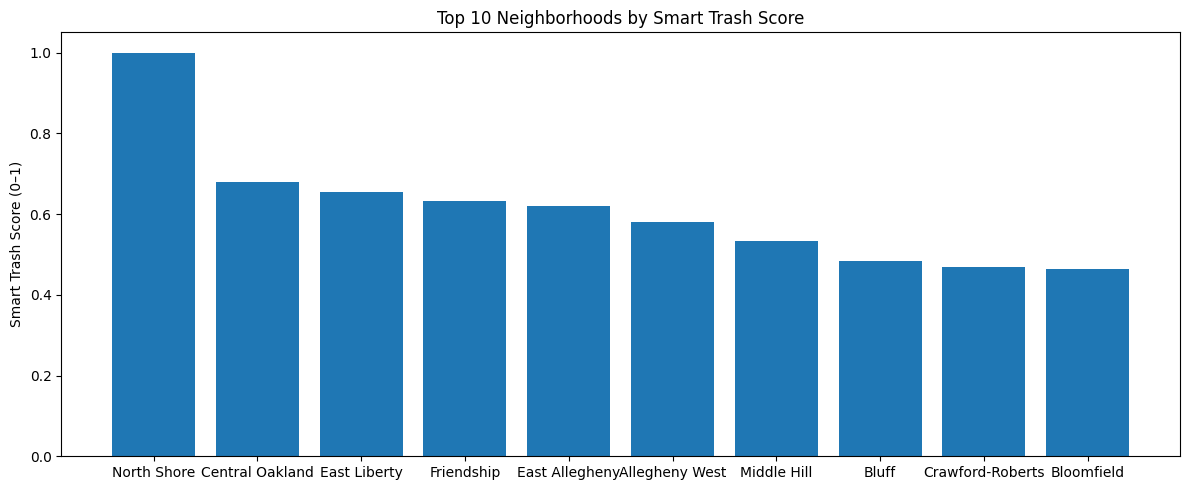

In [14]:
sorted_scores = (
    smart_trash_metric
    .sort_values("trash_score", ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 5))
plt.bar(sorted_scores["hood"], sorted_scores["trash_score"])
plt.ylabel("Smart Trash Score (0–1)")
plt.title("Top 10 Neighborhoods by Smart Trash Score")
plt.tight_layout()
plt.show()

## Discussion and reflection

Under our smart trash metric, neighborhoods with the highest scores appear to be:

- North Shore
- Central Oakland
- East Liberty
- Friendship
- East Allegheny

These areas tend to have many smart trash containers relative to their size, which suggests:

- Better access to waste disposal
- Potentially cleaner streets and more convenient public spaces

On the other hand, neighborhoods with low scores have few or no smart trash containers per square mile. This might indicate:

- Less investment in smart trash infrastructure so far, or
- Lower observed demand for these containers

**Limitations**

- I only consider *smart* trash containers, not all types of trash cans.
- We do not account for population or foot traffic — a small neighborhood with high density might still serve fewer people.
- The metric does not tell us whether containers are actually being used effectively.

Overall, the Smart Trash Score captures one aspect of "bestness":
> how convenient and modern the neighborhood's public waste infrastructure is,
and it will be combined with parking and walkability metrics in our final analysis.